# Load and create data sets

Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.causal_forest import CausalForest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)
all_features = df.columns.values[:12].tolist()

Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [2]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [3]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Size of data set: {data.shape[0]:,}")
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
obs_df = df[:train_size]
train_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = train_df[keep]
print("Observational (naive) setup")
print_outcomes(obs_df)
print("-------------")
exp_df = train_df.sample(n=obs_df.shape[0],random_state=42)
print("Experimental setup")
print_outcomes(exp_df)
print("-------------")
print("Entire data")
print_outcomes(df)

Observational (naive) setup
Size of data set: 6,297,527
Avg. Outcome (treated): 5.31%
Avg. Outcome (control): 1.23%
Estimated avg. effect: 4.08%
-------------
Experimental setup
Size of data set: 6,297,527
Avg. Outcome (treated): 4.86%
Avg. Outcome (control): 3.8%
Estimated avg. effect: 1.06%
-------------
Entire data
Size of data set: 13,979,592
Avg. Outcome (treated): 4.85%
Avg. Outcome (control): 3.82%
Estimated avg. effect: 1.03%


Build causal tree using observational data. Control for observable confounding.

In [4]:
def fit_tree(df_causal, tree_type=CausalForest, min_samples_leaf=5000, tune=False, params=None, scoring=None):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        if params is None:
            params = range(1000, 10000, 1000)
        tuned_parameters = [{'min_samples_leaf': params}]
        grid_tree = GridSearchCV(tree_type(random_state=42, n_estimators=10), tuned_parameters, cv=4, 
                                 verbose=10, n_jobs=-1, scoring=scoring)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        tree_model = grid_tree.best_estimator_
        #X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)
        #best_score = 0
        #tree_model = None
        #for param in params:
        #    print(param)
        #    new_model = tree_type(min_samples_leaf=param, random_state=42, n_estimators=10)
        #    new_model.fit(X_train, y_train)
        #    new_score = new_model.score(X_test, y_test)
        #    print(new_score)
        #    if new_score > best_score:
        #        best_score = new_score
        #        tree_model = new_model
        #tree_model.fit(X, y)
        #print("Best parameters set found on development set:")
        #print(tree_model.min_samples_leaf)
    else:
        tree_model = tree_type(min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=10)
        tree_model.fit(X, y)   
    print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return tree_model

obs_tree = fit_tree(obs_df, tune=True, params=[8000, 16000, 32000, 64000, 128000])
#obs_tree = fit_tree(obs_df, min_samples_leaf=50000)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 36.3min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 41.4min finished


Best parameters set found on development set:
{'min_samples_leaf': 32000}
--- Time to fit (and tune) causal tree 2905.154270887375 seconds ---


Obtain evaluation data

In [5]:
eval_df = df[train_size:].copy()

Estimated average causal effect after accounting for observed confounding. 

In [6]:
print("Observational ('smart') setup")
obs_preds = obs_tree.predict(eval_df[limited_features])
obs_avg_effect = obs_preds.mean()
print(f"Estimated avg. effect: {np.round(obs_avg_effect*100, 2)}%")

Observational ('smart') setup
Estimated avg. effect: 2.89%


# Does the confounding hurt decision making?

In [7]:
exp_tree = fit_tree(exp_df, min_samples_leaf=obs_tree.min_samples_leaf)
exp_preds = exp_tree.predict(eval_df[limited_features])

--- Time to fit (and tune) causal tree 386.9524929523468 seconds ---


In this case, the experimental data is large, so it hurts.

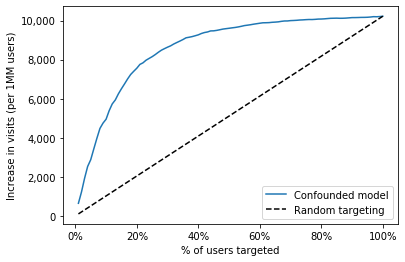

In [91]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]
total_impressions = 1000000
size = 100

def plot_random(e_df):
    means = e_df.groupby('treatment').visit.mean()
    avg_effect = means.loc[1]-means.loc[0]
    fractions = (np.arange(size)+1)/size
    plt.plot(fractions*100, fractions*avg_effect*total_impressions, 
             color='black', linestyle='dashed', label="Random targeting")
    plt.legend()

def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        effect = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction * total_impressions
        fractions.append(fraction)
        effects.append(effect)
    figs = plt.plot(np.array(fractions)*100, effects, label=title)
    plt.xlabel("% of users targeted")
    plt.ylabel("Increase in visits (per 1MM users)")
    # Set Y axis
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    figs[0].axes.yaxis.set_major_formatter(tick)
    # Set X axis
    figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()

#eval_df['pred'] = exp_preds
#evaluate(eval_df, "Targeting w. unconfounded data")
eval_df['pred'] = obs_preds
evaluate(eval_df, "Confounded model")
plot_random(eval_df)
#plt.title("Training data: 6.3 million")
plt.savefig("ranking_decisions.png", dpi=200, bbox_inches="tight")

But if there was less data, the bias may actually cancel some errors due to variance, benefiting decision making.

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    9.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.2s finished


Best parameters set found on development set:
{'min_samples_leaf': 4000}
--- Time to fit (and tune) causal tree 11.545586824417114 seconds ---
--- Time to fit (and tune) causal tree 0.8294336795806885 seconds ---
-- Experimental setup --
Estimated avg. effect: 1.34%
-- Observational setup --
Estimated avg. effect: 2.98%


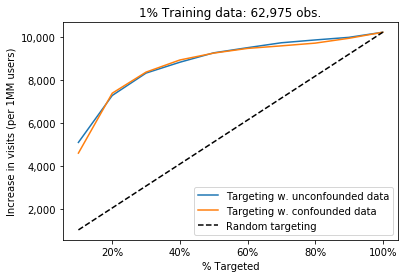

In [9]:
small_size = int(obs_df.shape[0]*0.01)
o_small_tree = fit_tree(obs_df.sample(small_size, random_state=42), tune=True, params=[1000, 2000, 4000, 8000, 16000])
e_small_tree = fit_tree(exp_df.sample(small_size, random_state=42), min_samples_leaf=o_small_tree.min_samples_leaf)
o_small_preds = o_small_tree.predict(eval_df[limited_features])
e_small_preds = e_small_tree.predict(eval_df[limited_features])
eval_df['pred'] = e_small_preds
evaluate(eval_df, "Targeting w. unconfounded data")
print("-- Experimental setup --")
print(f"Estimated avg. effect: {np.round(e_small_preds.mean()*100, 2)}%")
eval_df['pred'] = o_small_preds
evaluate(eval_df, "Targeting w. confounded data")
print("-- Observational setup --")
print(f"Estimated avg. effect: {np.round(o_small_preds.mean()*100, 2)}%")
plot_random(eval_df)
plt.title(f"1% Training data: {small_size:,} obs.")
plt.show()

# Approach 1: Domain Knowledge

Fit outcome tree.

In [10]:
outcome_tree = fit_tree(train_df, tree_type=RandomForestClassifier, tune=True,
                        scoring='roc_auc', params=[100, 200, 500, 1000, 2000])

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 17.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 20.4min finished


Best parameters set found on development set:
{'min_samples_leaf': 200}
--- Time to fit (and tune) causal tree 1450.5714466571808 seconds ---


Check out if there is a correlation between outcomes and estimated effects.

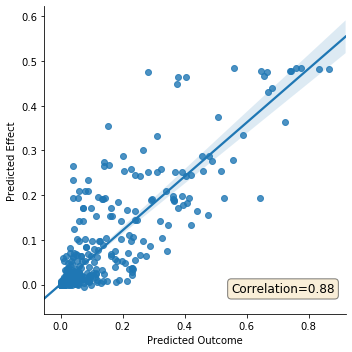

In [88]:
outcome_preds = outcome_tree.predict_proba(eval_df[limited_features + ['treatment']])[:, 1]
obs_preds = obs_tree.predict(eval_df[limited_features])
df_pred = pd.DataFrame({"Predicted Outcome": outcome_preds, "Predicted Effect": obs_preds})
sns.lmplot(x='Predicted Outcome',y='Predicted Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True)
#print(spearmanr(obs_preds, outcome_preds))
coef = round(np.corrcoef(obs_preds, outcome_preds)[0, 1], 2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.55, 0.005, f"Correlation={coef}", fontsize=12, verticalalignment='top', bbox=props)
plt.savefig("correlation_obs.png", dpi=200, bbox_inches="tight")

Of course, this correlation is likely to be exaggerated. Compare with a model trained with unconfounded data.

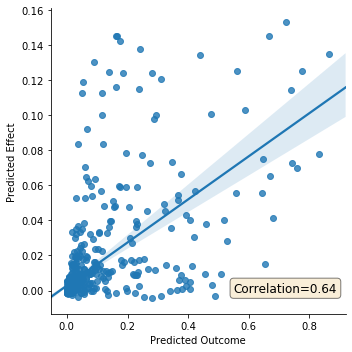

In [89]:
df_pred = pd.DataFrame({"Predicted Outcome": outcome_preds, "Predicted Effect": exp_preds})
sns.lmplot(x='Predicted Outcome',y='Predicted Effect',data=df_pred.sample(1000, random_state=42),fit_reg=True)
#print(spearmanr(exp_preds, outcome_preds))
coef = round(np.corrcoef(exp_preds, outcome_preds)[0, 1], 2) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.55, 0.005, f"Correlation={coef}", fontsize=12, verticalalignment='top', bbox=props)
plt.savefig("correlation_exp.png", dpi=200, bbox_inches="tight")

# Approach 2: Find out which customers are profitable

Suppose visit value is \\$ 0.50 and the cost is \\$ 0.01. How does the bias may affect ability to identify profitable customers?

In [74]:
visit_value = 0.49
ad_cost = 0.01
boundary = ad_cost/(visit_value+ad_cost)

def get_avg_benefit(e_df, boundary=None):
    if boundary is None:
        boundary = ad_cost/(visit_value+ad_cost)
    targeted = e_df.pred > boundary 
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    fraction = targeted.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction 
    benefit = (additional_visits*visit_value - fraction*ad_cost)*total_impressions
    print(f"Benefit ($) per 1 MM users: {round(benefit):,}")
    return benefit

print("Real benefit (compared with sensitivity analysis)")
print("------")
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
print("Experimental")
eval_df['pred'] = exp_preds
exp_benefit = get_avg_benefit(eval_df)

Real benefit (compared with sensitivity analysis)
------
Observational
Benefit ($) per 1 MM users: 1,753.0
Experimental
Benefit ($) per 1 MM users: 2,284.0


Get cross-validation predictions.

In [75]:
X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
cross_preds = cross_val_predict(CausalForest(min_samples_leaf=obs_tree.min_samples_leaf, random_state=42, n_estimators=10), 
                                X, y, cv=5, verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [86]:
bias_size = 0.87
real_size = (1-bias_size)
additional_visits = ((estimated_effects * real_size) * targeted).mean()
benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
benefit    

-56.0

Assess how much could the bias affect the decisions.

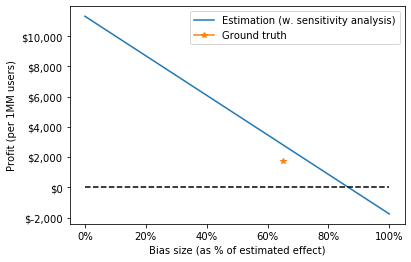

In [92]:
targeted = cross_preds > boundary
biased_avg_effect = obs_preds.mean()
estimated_effects = obs_tree.predict(obs_df[limited_features])

real_avg_bias = round(1 - avg_effect/biased_avg_effect, 2)

bias_sizes = np.arange(11)/10
benefits = []
for bias_size in bias_sizes:
    real_size = (1-bias_size)
    additional_visits = ((estimated_effects * real_size) * targeted).mean()
    benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
    benefits.append(benefit)

figs = plt.plot(bias_sizes*100, benefits, label="Estimation (w. sensitivity analysis)")
plt.xlabel("Bias size (as % of estimated effect)")
plt.ylabel("Profit (per 1MM users)")
# Set Y axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
figs[0].axes.yaxis.set_major_formatter(tick)
# Set X axis
figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
# Break-even line
plt.plot([0, 100], [0, 0], linestyle='--', color='black')
plt.plot([real_avg_bias*100], [obs_benefit], marker="*", label="Ground truth")
plt.legend()
plt.savefig("sensitivity_analysis.png", dpi=200, bbox_inches="tight")

# Approach 3: What if there is some experimental data?

What's the best tree we could get with limited experimental data? 

In [123]:
limited_exp = exp_df.sample(50000,random_state=42)
limited_tree = fit_tree(limited_exp, tune=True, params=np.arange(1, 11)*1000)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.3s finished


Best parameters set found on development set:
{'min_samples_leaf': 1000}
--- Time to fit (and tune) causal tree 9.830873727798462 seconds ---


Compare each other. Experimental does better.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


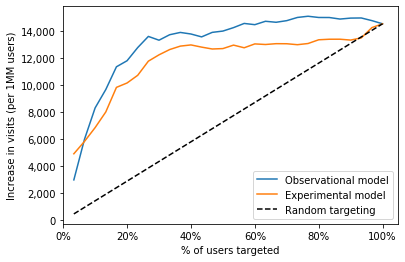

In [132]:
X = limited_exp[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  limited_exp.visit
exp_cross_preds = cross_val_predict(CausalForest(min_samples_leaf=limited_tree.min_samples_leaf, random_state=42, 
                                                 n_estimators=10), X, y, cv=10, verbose=10)

copy_exp_df = limited_exp.copy()
size=30
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
evaluate(copy_exp_df, "Observational model")
copy_exp_df['pred'] = exp_cross_preds
evaluate(copy_exp_df, "Experimental model")
plot_random(copy_exp_df)
plt.xlim(left=0)
plt.savefig("eval_comparison.png", dpi=200, bbox_inches="tight")

Average effect estimated by the experimental tree.

In [126]:
exp_cross_preds.mean() * 100

1.2585032074228768

Benefit evaluation

In [131]:
print("Observational")
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
obs_benefit = get_avg_benefit(copy_exp_df)
print("Experimental")
copy_exp_df['pred'] = exp_cross_preds
exp_benefit = get_avg_benefit(copy_exp_df)

Observational
Benefit ($) per 1 MM users: 3,742.0
Experimental
Benefit ($) per 1 MM users: 3,130.0


In [128]:
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
print("Experimental")
eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
exp_benefit = get_avg_benefit(eval_df)

Observational
Benefit ($) per 1 MM users: 1,753.0
Experimental
Benefit ($) per 1 MM users: 1,598.0


Observational
Experimental


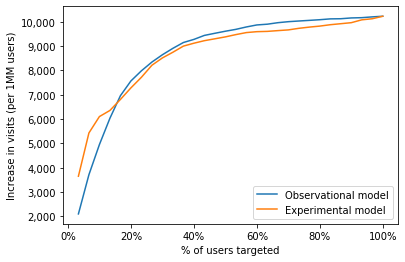

In [129]:
print("Observational")
eval_df['pred'] = obs_preds
evaluate(eval_df, "Observational model")
print("Experimental")
eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
evaluate(eval_df, "Experimental model")

# Approach 4: Benefit vs. cost in experimentation

In [142]:
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
exp_benefits = []
    
for sample_size in [250000, 500000, 1000000, 2000000, 4000000, exp_df.shape[0]]:
    print(sample_size)
    limited_exp = exp_df.sample(sample_size,random_state=42)
    limited_tree = fit_tree(limited_exp, min_samples_leaf=exp_tree.min_samples_leaf)
    eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
    exp_benefit = get_avg_benefit(eval_df)
    exp_benefits.append(exp_benefit)
    print(f"Improvement: {exp_benefit - obs_benefit}")
    print("------------------")

Observational
Benefit ($) per 1 MM users: 1,753.0
250000
--- Time to fit (and tune) causal tree 3.6801798343658447 seconds ---
Benefit ($) per 1 MM users: 1,499.0
Improvement: -254.09587901164537
------------------
500000
--- Time to fit (and tune) causal tree 17.870155334472656 seconds ---
Benefit ($) per 1 MM users: 2,147.0
Improvement: 394.03618783508546
------------------
1000000
--- Time to fit (and tune) causal tree 55.77349638938904 seconds ---
Benefit ($) per 1 MM users: 2,136.0
Improvement: 382.455650117156
------------------
2000000
--- Time to fit (and tune) causal tree 142.3461148738861 seconds ---
Benefit ($) per 1 MM users: 2,290.0
Improvement: 536.1860038733853
------------------
4000000
--- Time to fit (and tune) causal tree 216.1050317287445 seconds ---
Benefit ($) per 1 MM users: 2,202.0
Improvement: 448.11438932434385
------------------
6297527
--- Time to fit (and tune) causal tree 360.2350928783417 seconds ---
Benefit ($) per 1 MM users: 2,300.0
Improvement: 546.08

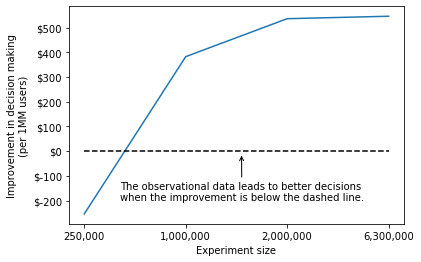

In [213]:
y_points = (np.array(exp_benefits) - obs_benefit)[[0, 2, 3, 5]]
x_labels = ["250,000", "1,000,000", "2,000,000", "6,300,000"]
x_points = np.arange(4)
figs = plt.plot(x_points, y_points)
plt.xlabel("Experiment size")
plt.ylabel("Improvement in decision making\n(per 1MM users)")
plt.xticks(x_points, x_labels)
#plt.grid(True,axis='y')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
figs[0].axes.yaxis.set_major_formatter(tick)
plt.plot([0, 3], [0, 0], color='black', linestyle='dashed')
#plt.text(0.8, 120, "The observational data is better when the\nimprovement is below the dashed line.")
plt.annotate("The observational data leads to better decisions\nwhen the improvement is below the dashed line.", 
             xy=(1.55, -10), xytext=(0.35, -200), arrowprops={'arrowstyle':'->'})
#plt.arrow(1.8, 100, 0, -75, length_includes_head=True, head_width=0.1, head_length=0.1, shape="full")
plt.savefig("learning_curve.png", dpi=200, bbox_inches="tight")

In [214]:
eval_df['pred'] = np.random.uniform(eval_df.shape[0])
print("Random targeting")
random_benefit = get_avg_benefit(eval_df)

Random targeting
Benefit ($) per 1 MM users: -4,991.0


Minimum inference set sizes (in millions)


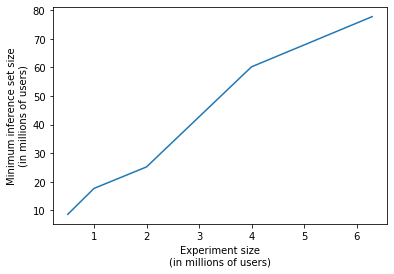

In [230]:
break_even_ratios = (obs_benefit - random_benefit)/(np.array(exp_benefits) - obs_benefit)
print("Minimum inference set sizes (in millions)")
x_points = np.array([500000, 1000000, 2000000, 4000000, exp_df.shape[0]]) /1000000
y_points = np.array(break_even_ratios[1:]) * x_points 

figs = plt.plot(x_points, y_points)
plt.xlabel("Experiment size\n(in millions of users)")
plt.ylabel("Minimum inference set size\n(in millions of users)")
plt.savefig("minimum_set.png", dpi=200, bbox_inches="tight")

# Setup

1. Show that we are overestimating the effect by a lot. 
2. Domain Knowledge: Do we know anything about the nature of the confounding? In the advertising setup, is very common for ads to be targeted to the people most likely to convert. In other words, the more likely someone is to convert, the more likely this person is to be treated, so confounding is likely to be stronger for likely buyers. But... If the people more likely to convert are also more likely to be affected, that confounding will not be particularly harmful for decision making. We can check whether outcomes and effects seem to be correlated in the observational data. This is the case: so, we should expect to overestimate the effect for individuals with larger effects, which should be (in general) helpful. Show that the confounding is helpful for cases where there is little data (bias helps!). The bias is less helpful the more data we get. Emphasize that this is helpful to identify the people most likely to convert, not to identify the profitable individuals.
3. Sensitivity analysis: Basic setup, we could assess how much are we overestimating things with a simple approach. In practice, that may be too simplistic, because the confounding may vary quite a bit. Use a beta distribution of the confounding bias. Heat map varying the degree of confounding bias and the variance (used to assess how much the bias could vary across individuals). According to the analysis we should be fine unless the variance is too large, or the degree of confounding is too large. 
4. We have some experimental data available. Should we use the experimental data or the observational data? Use experimental data as a test set.
5. What if we were to invest in the experiment anyway. Would that lead to better results?